### Polynomial Regression

We want to model the strength of iron welded together with the current used during the welding process. Thus, we only have one feature to model.


Firstly, we examine the data to find a suitable model.

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

# Plotting configuration
%config InlineBackend.figure_format = 'retina'
plt.style.use(['science', 'notebook', 'grid'])

In [2]:
df = pd.read_csv('data/polynomial_regression.csv')
df.head()

,y,x
0,80.197118,-2.566618
1,96.100338,-2.126984
2,102.216391,-2.041836
3,115.876434,-0.949271
4,111.296920,-0.771169


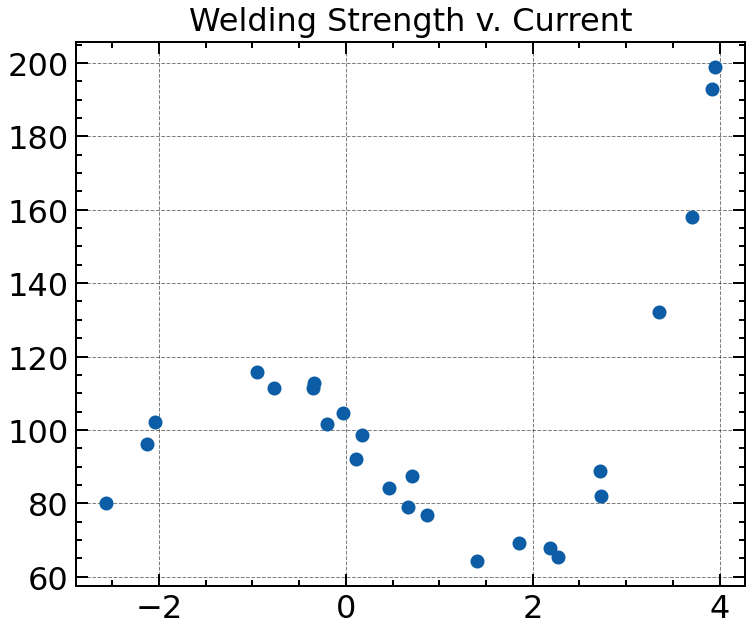

In [3]:
fig, ax = plt.subplots()
ax.scatter(df['x'], df['y'])
ax.set_title('Welding Strength v. Current')

fig.set_size_inches(6, 5)
plt.show()

### Model Selection

The data is suggesting a polynomial fit. A hypothesised model would be:

$$
Y_i = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 +\varepsilon_i
$$

To estimate $\hat{\mathbf{\beta}}$ we solve the OLS problem using the normal equations, yielding:
$$
\hat{\mathbf{\beta}} =\mathbf{X}^{\dagger}\mathbf{Y} = (\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{X}^{\text{T}}\mathbf{Y}
$$

Using the design matrix $\mathbf{X}$ and output data $\mathbf{Y}$. In addition, we will calculate $R^2$, to esimate how well the model works on the training data. Recall:
$$
R^2 = 1 - \frac{\text{SSE}}{\text{SST}}
$$

In which:

$$
\text{SST} = \sum_{i=1}^n(y_i - \bar{y})^2
$$
$$
\text{SSE} = \sum_{i=1}^n(y_i - \hat{y}_i)^2
$$

In [4]:
# Creating the design matrix.
n_observations = len(df)
x0 = np.ones(n_observations)
x1 = np.array(df['x'])
x2 = np.array((df['x'] ** 2))
x3 = np.array((df['x'] ** 3))
X = np.stack([x0, x1, x2, x3]).T
Y = np.array(df['y'])

# Solving the normal equations.
beta_ols = np.linalg.inv(X.T @ X) @ X.T @ Y
H_hat = X @ np.linalg.inv(X.T @ X) @ X.T
print('OLS beta coefficients:', beta_ols)

# Calculating R2.
sst = (Y - np.mean(Y)).T @ (Y - np.mean(Y))
sse = (Y - H_hat @ Y).T @ (Y - H_hat @ Y)
r2 = 1 - sse / sst
print('R-square value:', r2)

OLS beta coefficients: [ 99.31736762 -26.31042095  -3.3667638    4.1069712 ]
R-square value: 0.9871777691798865


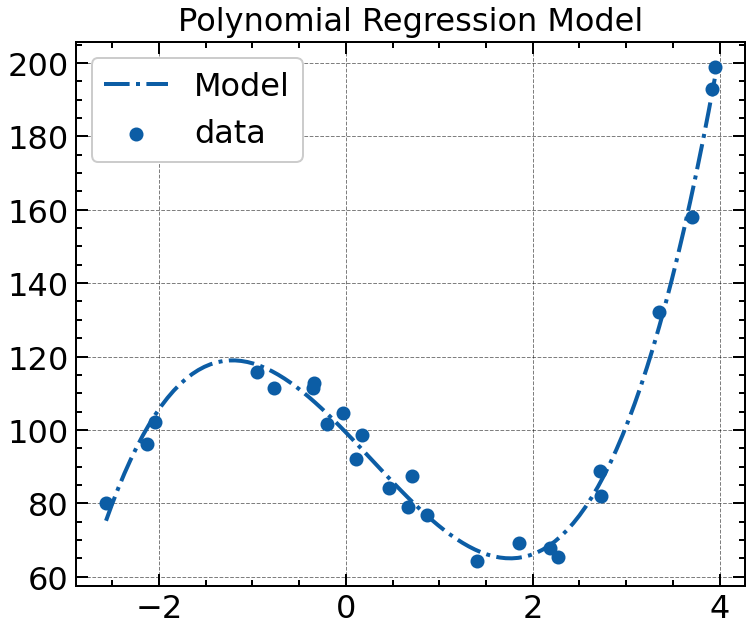

In [5]:
# Plotting the mean - model.
x = np.linspace(np.min(df['x']), np.max(df['x']), 100)
input = np.stack([np.ones(100), x, x**2, x**3]).T
y = beta_ols @ input.T

fig, ax = plt.subplots()

ax.plot(x, y, linestyle='dashdot', label='Model')
ax.scatter(df['x'], df['y'], label='data')
ax.legend()
ax.set_title('Polynomial Regression Model')

fig.set_size_inches(6, 5)
plt.show()

### Confidence and Prediction Bands

As explained in the notebook: ```exponential_regression.ipynb```, we can find confidence and prediction intervals for the mean of the model and new observations respectivley. Calculating confidence and prediction intervals for the domain of the model we can ascertain confidence and prediction bands. These are calculated as shown below.
$$
I_{\mu_Y}^{1-\alpha} = \mathbf{x}^{\text{T}}\hat{\mathbf{\beta}} \mp t_{\frac{\alpha}{2}}(n-k-1)s\sqrt{\mathbf{x}^{\text{T}}(\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{x}}
$$


$$
I_{Y}^{1-\alpha} = \mathbf{x}^{\text{T}}\hat{\mathbf{\beta}} \mp t_{\frac{\alpha}{2}}(n-k-1)s\sqrt{1+\mathbf{x}^{\text{T}}(\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{x}}
$$

In [6]:
from scipy.stats import t

# Estimating sigma.
n_features = 3
sigma_hat = sse / (n_observations - n_features - 1)

# Creating the upper and lower CI bounds (pre-defined to 95 % confidence).
def CI_bounds(obs: np.array, beta: np.array, X: np.array, sigma: float) -> list:
    lower_bound = obs.T @ beta - t.ppf(0.025, n_observations - n_features - 1) * sigma * np.sqrt(obs.T @ np.linalg.inv(X.T @ X) @ obs)
    upper_bound = obs.T @ beta + t.ppf(0.025, n_observations - n_features - 1) * sigma * np.sqrt(obs.T @ np.linalg.inv(X.T @ X) @ obs)
    return lower_bound, upper_bound

# Creating the upper and lower PI bounds (pre-defined to 95 % confidence).
def PI_bounds(obs: np.array, beta: np.array, X: np.array, sigma: float) -> list:
    lower_bound = obs.T @ beta - t.ppf(0.025, n_observations - n_features - 1) * sigma * np.sqrt(1 + obs.T @ np.linalg.inv(X.T @ X) @ obs)
    upper_bound = obs.T @ beta + t.ppf(0.025, n_observations - n_features - 1) * sigma * np.sqrt(1 + obs.T @ np.linalg.inv(X.T @ X) @ obs)
    return lower_bound, upper_bound

# Creating CI and PI bands.
x = np.linspace(np.min(df['x']), np.max(df['x']), 100)
conf_band = []
pred_band = []
for observation in x:
    obs = np.array([1, observation, observation ** 2, observation ** 3])
    conf_band.append(CI_bounds(obs, beta_ols, X, sigma_hat))
    pred_band.append(PI_bounds(obs, beta_ols, X, sigma_hat))

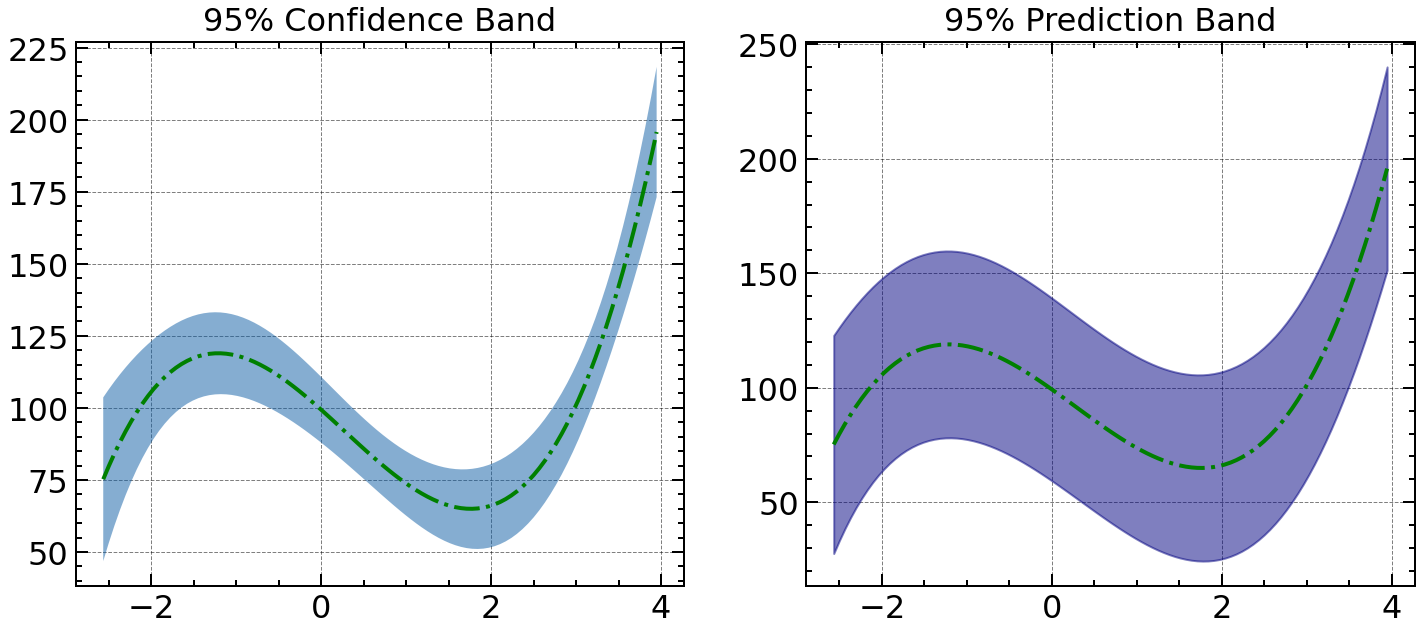

In [7]:
# Plotting confidence bands and prediction bands.
fig, axs = plt.subplots(1, 2)
conf_lower_bound = [i[0] for i in conf_band]
conf_upper_bound = [i[1] for i in conf_band]
axs[0].fill_between(x, conf_lower_bound, conf_upper_bound, alpha=0.5)
axs[0].plot(x, y, linestyle='dashdot', color='green')
axs[0].set_title('95% Confidence Band')

pred_lower_bound = [i[0] for i in pred_band]
pred_upper_bound = [i[1] for i in pred_band]
axs[1].fill_between(x, pred_lower_bound, pred_upper_bound, alpha=0.5, color='navy')
axs[1].plot(x, y, linestyle='dashdot', color='green')
axs[1].set_title('95% Prediction Band')

fig.set_size_inches(12, 5)
plt.show()

### Tikhonov Regularization (L2 Ridge Regression)

Let us now add more polynomial terms. In doing so we can capture more complicated patterns. However, with the small sample size in comparision to the number of paramters, overfitting will become an issue.

The new model is:
$$
Y_i = \sum_{i=0}^{15}\beta_ix^i +\varepsilon_i
$$
We solve the normal equations and examine the output.

In [8]:
# Creating the design matrix.
n_observations = len(df)

polynomial_degree_list = []
polynomial_degree = 15

x0 = np.ones(n_observations)
polynomial_degree_list.append(x0)
for i in range(1, polynomial_degree+1):
    polynomial_degree_list.append(np.array(df['x'] ** i))
X = np.stack(polynomial_degree_list).T
Y = np.array(df['y'])

# Solving the normal equations.
beta_ols = np.linalg.inv(X.T @ X) @ X.T @ Y
H_hat = X @ np.linalg.inv(X.T @ X) @ X.T
print('OLS beta coefficients:', beta_ols)

# Calculating R2.
sst = (Y - np.mean(Y)).T @ (Y - np.mean(Y))
sse = (Y - H_hat @ Y).T @ (Y - H_hat @ Y)
r2 = 1 - sse / sst
print('R-square value:', r2)

OLS beta coefficients: [ 9.99126702e+01 -3.58579370e+01  1.82535572e+01  4.66932410e+01
 -8.84756746e+01 -3.03229090e+01  9.76169532e+01 -1.49348881e+01
 -3.46880609e+01  1.30387328e+01  3.78953991e+00 -2.65834727e+00
  1.65969059e-01  1.51752831e-01 -3.61473837e-02  2.47908450e-03]
R-square value: 0.994095869740339


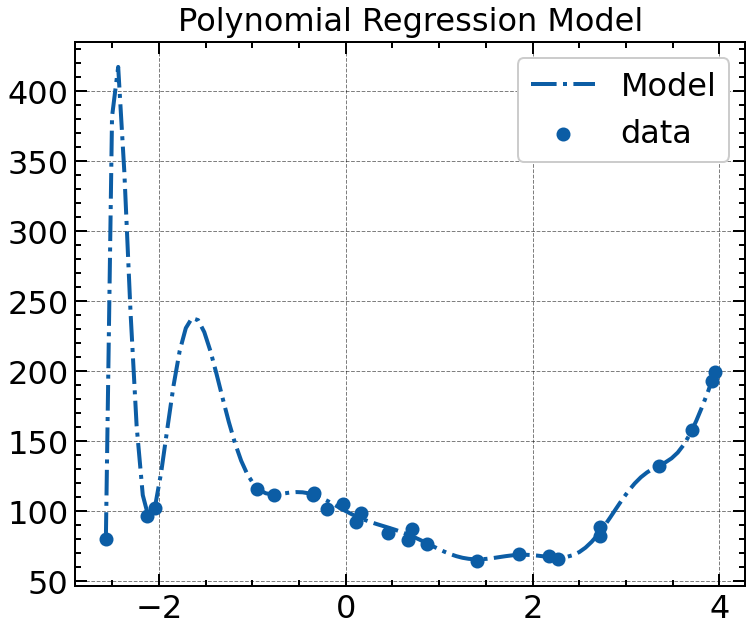

In [9]:
# Plotting the mean - model.
x = np.linspace(np.min(df['x']), np.max(df['x']), 100)

input_list = []
input_list.append(np.ones(100))

for i in range(1, polynomial_degree+1):
    input_list.append(x ** i)

input = np.stack(input_list).T
y = beta_ols @ input.T

fig, ax = plt.subplots()

ax.plot(x, y, linestyle='dashdot', label='Model')
ax.scatter(df['x'], df['y'], label='data')
ax.legend()
ax.set_title('Polynomial Regression Model')

fig.set_size_inches(6, 5)
plt.show()

In order to solve this overfitting model we employ Tikhonov regularization, also known as L2 Ridge Regression. In ridge regression we add a penalizing term for large values of the parameters in $\mathbf{\beta}$, estimated from the OLS methodology. The objective function then becomes:

$$
\text{min} ~~||\mathbf{X}\mathbf{\beta} - \mathbf{y}||_2^2 + \lambda ||\mathbf{\beta}||_2^2
$$

The normal equations for this modified least squares problem is:

$$
\hat{\mathbf{\beta}} = (\mathbf{X}^{\text{T}}\mathbf{X} + \lambda \mathbf{I}_{n+1})^{-1}\mathbf{X}^{\text{T}}\mathbf{Y}
$$

Note, the issue of selecting $\lambda$ is done on an ad-hoc basis until a satisfactory model has been ascertained.

In [10]:
# Creating the design matrix.
n_observations = len(df)

polynomial_degree_list = []
polynomial_degree = 15
lamb = 1

x0 = np.ones(n_observations)
polynomial_degree_list.append(x0)
for i in range(1, polynomial_degree+1):
    polynomial_degree_list.append(np.array(df['x'] ** i))
X = np.stack(polynomial_degree_list).T
Y = np.array(df['y'])

# Solving the normal equations.
beta_ols = np.linalg.inv(X.T @ X + lamb * np.identity(polynomial_degree + 1)) @ X.T @ Y
H_hat = X @ np.linalg.inv(X.T @ X) @ X.T
print('OLS beta coefficients:', beta_ols)

# Calculating R2.
sst = (Y - np.mean(Y)).T @ (Y - np.mean(Y))
sse = (Y - H_hat @ Y).T @ (Y - H_hat @ Y)
r2 = 1 - sse / sst
print('R-square value:', r2)

OLS beta coefficients: [ 8.82955118e+01 -1.48783127e+01  7.48554813e+00 -5.57360393e+00
  6.78945579e-01 -1.86506914e+00  7.34024782e-01  1.89441971e+00
 -1.11763073e+00 -2.04932090e-01  2.59235977e-01 -2.74911096e-02
 -1.66151280e-02  4.06374157e-03 -9.62814402e-05 -2.75262479e-05]
R-square value: 0.994095869740339


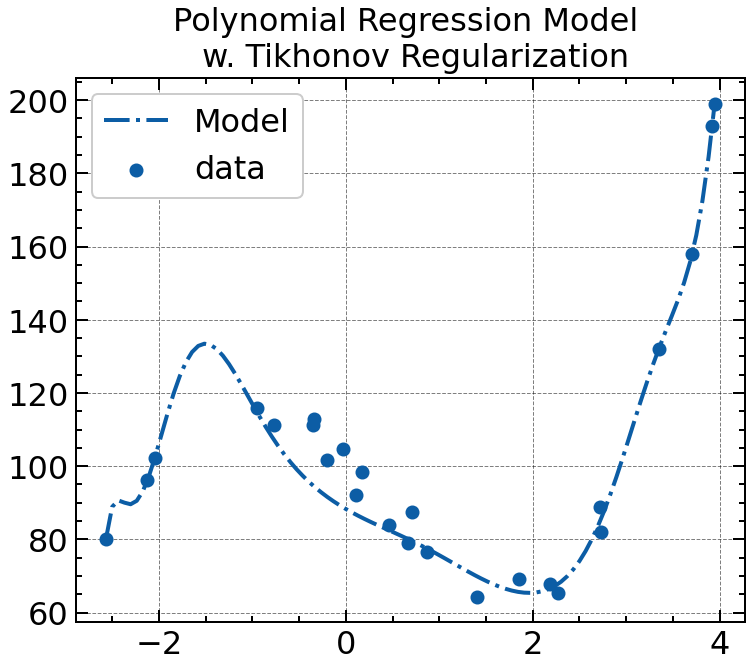

In [11]:
# Plotting the mean - model.
x = np.linspace(np.min(df['x']), np.max(df['x']), 100)

input_list = []
input_list.append(np.ones(100))

for i in range(1, polynomial_degree+1):
    input_list.append(x ** i)

input = np.stack(input_list).T
y = beta_ols @ input.T

fig, ax = plt.subplots()

ax.plot(x, y, linestyle='dashdot', label='Model')
ax.scatter(df['x'], df['y'], label='data')
ax.legend()
ax.set_title('Polynomial Regression Model \n w. Tikhonov Regularization')

fig.set_size_inches(6, 5)
plt.show()